In [1]:
from numba import jit
import numpy as np

@jit(nogil=True, fastmath=True)
def zigzagiterator(min_i, max_i, target):
    yield target
    for d in range(1, 2+max(target - min_i, max_i - target)):
        if target+d<max_i:
            yield target+d
        if target-d>=min_i:
            yield target-d

@jit(nogil=True, fastmath=True)
def create_polygon_jit(points, n, target_n, gridsize, search_range, curr_area, reached_max_i, val_max_j, reached_min_j, min_area, soln):
    
    if n >= 3:
        #Solution found
        if n == target_n:
            soln[:] = points
            min_area[0] = curr_area
            return True
        
        #Stage variables
        reached_max_i = reached_max_i or (points[n-1][0] == gridsize - 1)
        if val_max_j < 0:
            if points[n-2][1] >= points[n-1][1]:
                val_max_j = points[n-2][1]
        reached_min_j = reached_min_j or (reached_max_i and (points[n-2][1] <= points[n-1][1]))

    if not reached_max_i:
        #stage 1,2 i (only move ahead)
        min_i = points[n-1][0]
        max_i = min(gridsize, points[n-1][0] + search_range + 1)
        if val_max_j < 0:
            #stage 1 j (can't do anything)
            min_j = max(1, points[n-1][1] - search_range)
            max_j = min(gridsize, points[n-1][1] + search_range + 1)
        else:
            #stage 2 j (only move down)
            min_j = max(val_max_j-gridsize-1, points[n-1][1] - search_range)
            max_j = points[n-1][1] + 1
    else:
        #stage 3,4 i (only move back)
        min_i = max(1, points[n-1][0] - search_range)
        max_i = points[n-1][0] + 1
        if not reached_min_j:
            #stage 3 j (can't do anything)
            min_j = max(val_max_j-gridsize-1, points[n-1][1] - search_range)
            max_j = min(val_max_j, points[n-1][1] + search_range + 1)
        else:
            #stage 4 j (only move up)
            min_j = points[n-1][1]
            max_j = min(0, points[n-1][1] + search_range + 1)
    
    if n>=2:
        x1, y1 = points[n-2][0]-points[n-1][0], points[n-2][1]-points[n-1][1]
    
    if not reached_max_i:
        target_i = (2*gridsize*n)//target_n
    else:
        target_i = 2*gridsize - (2*gridsize*n)//target_n
    #    min_i, max_i, i_step = max_i - 1, min_i - 1, -1
    #else:
    #    i_step = 1
    
    for i in zigzagiterator(min_i, max_i, target_i):#range(min_i, max_i, 1):#
        min_j_use = min_j
        max_j_use = max_j
        if n>=2:
            x2 = i-points[n-1][0]
                        
            #< 180 degree convex handled
            if x1 > 0: 
                min_j_use = max(min_j_use, 1+points[n-1][1]+((x2*y1)//x1))
            elif x1 < 0:
                max_j_use = min(max_j_use, 1+points[n-1][1]+((x2*y1+1)//x1))
            else: #x1 = 0
                if -x2*y1 <= 0:
                    continue
            
            #Acute not allowed
            if y1 > 0:
                max_j_use = min(max_j_use, 1+(points[n-1][1]+(-x1*x2)//y1))
            elif y1 < 0:
                min_j_use = max(min_j_use, 1+points[n-1][1]+(-x1*x2)//y1)                    
            else: #y1 = 0
                if x1*x2 > 0:
                    continue
                    
            if i == gridsize - 1:
                if n+2<target_n//2:
                    continue
                
            # 0,0 area handled
            if points[n-1][0] > 0: 
                max_j_use = min(max_j_use,(i*points[n-1][1]+1)//points[n-1][0])
            else:
                if points[n-1][1] <= 0 or i == 0:
                    continue
                    
        if reached_max_i:
            min_j_use, max_j_use, j_step = max_j_use - 1, min_j_use - 1, -1
        else:
            j_step = 1
        for j in range(min_j_use, max_j_use, j_step):
            if n>=2:
                add_area = i*points[n-1][1]-j*points[n-1][0] # 0,0 area
                if curr_area + add_area>= min_area[0]:
                    continue
            points[n][0], points[n][1] = i, j
            result = create_polygon_jit(points, n+1, target_n, gridsize, search_range, curr_area+add_area, reached_max_i, val_max_j, reached_min_j, min_area, soln)
    points[n][0], points[n][1] = 0,0 #not needed, but nice
    return True

In [2]:
import time
n = 17
gridsize = 11
points = np.array([(0,0)]*n) #List([(0,0)]*n)
results = []
soln = points.copy()
doublearea = np.array([2*gridsize**2])
start = time.perf_counter()
_ = create_polygon_jit(points, 1, n, gridsize, 3+gridsize//n, 0, False, -1, False, doublearea, soln)
print(round(time.perf_counter()-start, 2), "seconds,", doublearea[0], "area,", gridsize, "gridsize,", n, "n")

11.53 seconds, 151 area, 11 gridsize, 17 n


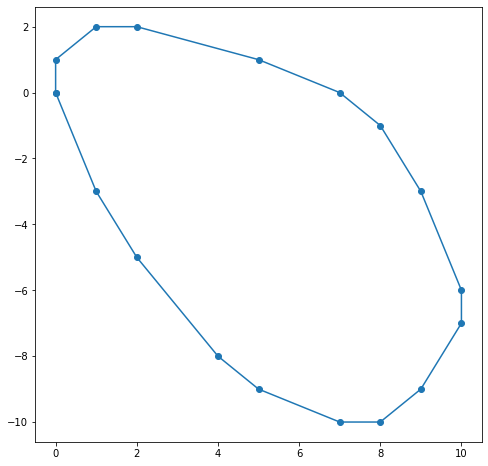

In [3]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [8, 8]
i,j = zip(*soln.tolist())
i = list(i) + [i[0]]
j = list(j) + [j[0]]
plt.plot(i,j)
plt.scatter(i,j)
plt.show()

In [4]:
from threading import Thread
def limited_time_calc(n, gridsize):    
    points = np.array([(0,0)]*n) #List([(0,0)]*n)
    results = []
    soln = points.copy()
    doublearea = np.array([2*gridsize**2])
    t = Thread(target = create_polygon_jit, args =(points, 1, n, gridsize, 2+(2*gridsize)//n, 0, False, -1, False, doublearea, soln))
    start = time.perf_counter()
    t.start()
    while t.is_alive():
        if time.perf_counter() - start < 15:
            if doublearea[0] == 2*gridsize**2:
                continue
            else:
                firstfoundtime = time.perf_counter()
                while t.is_alive():
                    if time.perf_counter() - firstfoundtime < 5:
                        continue
                    break
        break
    temp = doublearea[0]
    doublearea[0] = -1
    t.join()
    doublearea[0] = temp
    #_ = create_polygon_jit(points, 1, n, gridsize, 4, 0, False, -1, False, doublearea, soln)
    if not all(point==[0,0] for point in soln.tolist()):
        print(round(time.perf_counter()-start, 2), "seconds,", doublearea[0], "area,", gridsize, "gridsize,", n, "n")
        print("points:", soln.tolist())
    else:
        print(round(time.perf_counter()-start, 2), "seconds, failed")
    return doublearea[0]

In [5]:
n = 3
gridsize = 3
areasdict = {}
while True:
    area = limited_time_calc(n, gridsize)
    if area == 2*(gridsize**2):
        print("failed")
        gridsize += 1
    else:
        areasdict[n] = area
        n += 1

0.0 seconds, 1 area, 3 gridsize, 3 n
points: [[0, 0], [2, 1], [3, 1]]
0.0 seconds, 3 area, 3 gridsize, 4 n
points: [[0, 0], [1, 1], [3, 2], [4, 2]]
0.0 seconds, 8 area, 3 gridsize, 5 n
points: [[0, 0], [0, 1], [1, 2], [3, 2], [3, 1]]
0.0 seconds, 14 area, 3 gridsize, 6 n
points: [[0, 0], [0, 1], [1, 2], [3, 1], [4, 0], [4, -1]]
0.01 seconds, failed
failed
0.02 seconds, 13 area, 4 gridsize, 7 n
points: [[0, 0], [1, 1], [2, 1], [3, 0], [3, -1], [2, -2], [1, -2]]
0.01 seconds, 14 area, 4 gridsize, 8 n
points: [[0, 0], [0, 1], [1, 2], [2, 2], [3, 1], [3, 0], [2, -1], [1, -1]]
0.01 seconds, 27 area, 4 gridsize, 9 n
points: [[0, 0], [0, 1], [1, 2], [2, 2], [3, 1], [4, -1], [3, -3], [2, -3], [1, -2]]
0.01 seconds, 28 area, 4 gridsize, 10 n
points: [[0, 0], [0, 1], [1, 2], [2, 2], [3, 1], [4, -1], [4, -2], [3, -3], [2, -3], [1, -2]]
0.01 seconds, failed
failed
0.01 seconds, 43 area, 5 gridsize, 11 n
points: [[0, 0], [0, 1], [1, 2], [2, 2], [4, 1], [5, 0], [5, -1], [4, -3], [3, -4], [2, -4], [1

KeyboardInterrupt: 

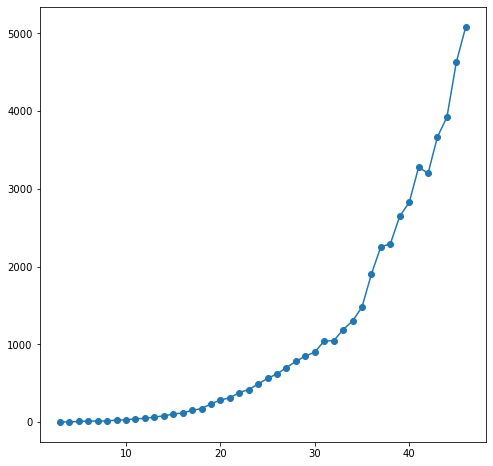

{3: 1, 4: 3, 5: 8, 6: 14, 7: 13, 8: 14, 9: 27, 10: 28, 11: 43, 12: 48, 13: 65, 14: 80, 15: 103, 16: 118, 17: 151, 18: 174, 19: 235, 20: 284, 21: 313, 22: 380, 23: 419, 24: 490, 25: 563, 26: 620, 27: 701, 28: 782, 29: 849, 30: 901, 31: 1045, 32: 1046, 33: 1190, 34: 1300, 35: 1480, 36: 1905, 37: 2256, 38: 2291, 39: 2648, 40: 2825, 41: 3277, 42: 3201, 43: 3670, 44: 3923, 45: 4632, 46: 5086}


In [9]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [8, 8]
i,j = zip(*areasdict.items())
i = list(i)
j = list(j)
plt.plot(i,j)
plt.scatter(i,j)
plt.show()
print(areasdict)